<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа» - Ускорение тестирования</b></h3>


## Импорт библиотек

In [41]:
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Импорт данных

In [42]:
data_path = "https://raw.githubusercontent.com/a-milenkin/Datasetes_for_Piplines/main/SkillBox/ab_speedup.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (50000, 2)


,group,metrica
strata,,
11,history,42.631346
6,history,14.844453
4,history,2.362768
37,history,79.494017
18,history,-22.627788
34,history,28.679378


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой результаты некоторого А/B-Теста. 

* `strata` - Некоторая информация по страту (группа), к которой относится пользователь. 
* `group` - Группа эксперимента - тестовая, контрольная или прошлая история. 
* `metrica` - Целивая метрика
    
</div>

<div class="alert alert-info">

<b>Задание:</b>    
    
Найти различие между группами, увеличив чувствительность тестов тремя способами поочередно:
* Бутстрап
* Стратификация
* CUPED
    
Вспомогательная статья Валерия Бабушкина про стратификацию и CUPED:

* habr.com/ru/company/yandex/blog/497804/

In [43]:
# Применение бутстрапа: создаем подвыборку с заменой
bootstrap = resample(data, replace=True, n_samples=1000, random_state=1)

In [44]:
# Применение стратификации: Разбиение на 10 подвыборок с сохранением пропорций
skf = StratifiedKFold(n_splits=10)

# Применим стратификацию к нашим данным (так как у нас всего одна группа, она будет игнорироваться)
for train_index, test_index in skf.split(data, data['group']):
    stratified_sample = data.iloc[test_index]
    break  # просто взяли первую подвыборку для демонстрации

In [45]:
# Применение CUPED
theta = data['metrica'].cov(data.index.to_series()) / data.index.to_series().var()
data['metrica_cuped'] = data['metrica'] - theta * (data.index.to_series() - data.index.to_series().mean())

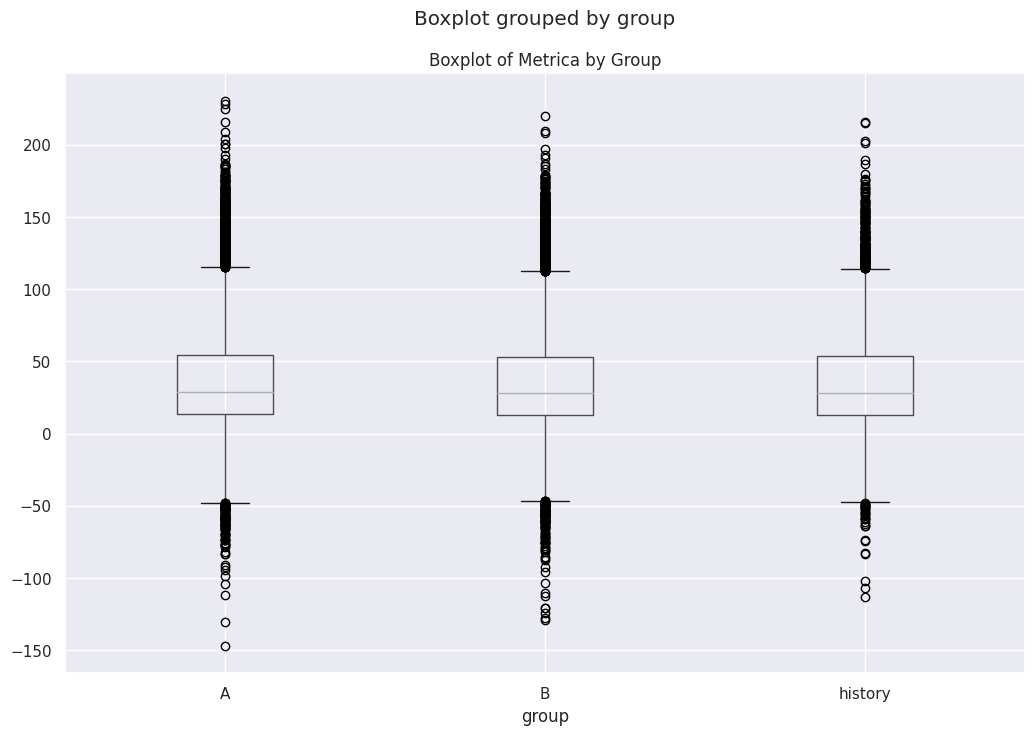

In [46]:
data.boxplot('metrica', by='group', figsize=(12, 8))
plt.title('Boxplot of Metrica by Group')
plt.show()

In [47]:
f, p = stats.f_oneway(data[data['group'] == 'A']['metrica'],
                      data[data['group'] == 'B']['metrica'],
                      data[data['group'] == 'history']['metrica'])

print(f'F-statistic: {f}')
print(f'p-value: {p}')

#p-value меньше порога значимости (0.05), делаем вывод, что есть статистически значимые различия между группами.


F-statistic: 3.1340719079362596
p-value: 0.043548698365134406
